In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from datetime import datetime as dt
from sklearn.model_selection import train_test_split
import catboost
from catboost import CatBoostClassifier

In [2]:
df_atlas = pd.read_csv('../data/Atlas Cechu Student Access.csv', encoding='utf-8')
df_payments = pd.read_csv('../data/Payments Student Access.csv', encoding='utf-8')
df_credits = pd.read_csv('../data/User Credits Student Access.csv', encoding='utf-8')

In [3]:
df_credits_cleaned = df_credits[df_credits['credits']>0]
df_payments_cleaned = df_payments[df_payments['user'].notna()]

In [4]:
from collections import defaultdict

grouped_cols = defaultdict(dict)

for col in df_atlas.columns:
    if "-" in col:
        group, key = col.split('-', 1)
        grouped_cols[group][key] = col
    else:
        grouped_cols[col][col] = col

structured_data = []
for _, row in df_atlas.iterrows():
    entry = {}
    for group, mapping in grouped_cols.items():
        entry[group] = [key for key, col in mapping.items() if row[col] == 1]
    structured_data.append(entry)

In [5]:
df_test = pd.DataFrame(structured_data)

In [6]:
df_test = df_test.drop(columns=['user_id'])

In [7]:
df_test3 = pd.concat([df_atlas['user_id'], df_test], axis=1, join='inner')

In [8]:
mapping_dicts = {}

for col in df_test3.columns:
    if col == 'user_id':
        continue

    # Convert lists to tuples to make them hashable (dict keys)
    unique_lists = df_test3[col].apply(lambda x: tuple(sorted(x))).unique()
    
    # Create mapping: list → ID
    mapping_dicts[col] = {lst: idx + 1 for idx, lst in enumerate(unique_lists)}

    # Apply mapping
    df_test3[col] = df_test3[col].apply(lambda x: mapping_dicts[col][tuple(sorted(x))])

In [9]:
df_merge_full = pd.merge(df_payments_cleaned, df_test3, how='inner', left_on='user', right_on='user_id')
df_merge_full.rename(columns={'credits_x':'credits_payments', 'credits_y':'credits_credits'})
df_merge_full = pd.get_dummies(df_merge_full, columns=['type'], drop_first=True)
df_merge_full = df_merge_full.astype({col: int for col in df_merge_full.select_dtypes(include='bool').columns})
df_merge_full['created_at'] = pd.to_datetime(df_merge_full['created_at'])
df_merge_full['month'] = df_merge_full['created_at'].dt.month
df_merge_full['year'] = df_merge_full['created_at'].dt.year

C:\Users\filip\AppData\Local\Temp\ipykernel_8652\2015201981.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_merge_full['month'] = df_merge_full['created_at'].dt.month
C:\Users\filip\AppData\Local\Temp\ipykernel_8652\2015201981.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_merge_full['year'] = df_merge_full['created_at'].dt.year


In [10]:
df_merge_ml = df_merge_full.drop(columns=['created_at'])

In [11]:
def get_split_values(df_merge_full, value:int):
    col_name = f'credits_{value}+'
    df_modeling = df_merge_full.drop(columns=['id', 'changed_at', 'user', 'batch', 'state', 'user_id'])
    df_modeling[col_name] = (df_modeling['credits'] > value).astype(int)
    df_modeling = df_modeling.drop(columns=['credits'])

    fig = px.bar(pd.DataFrame(df_modeling[col_name].value_counts().reset_index()), x=col_name, y='count', title='Credits Category Distribution')
    fig.show()
    
    df_modeling = df_modeling[df_modeling[col_name].isnull()==False] # clean data from null values
    return df_modeling, col_name

df_modeling, colname = get_split_values(df_merge_ml, 660)

C:\Users\filip\AppData\Local\Temp\ipykernel_8652\3820212930.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_modeling[col_name] = (df_modeling['credits'] > value).astype(int)


In [12]:
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek

y = df_modeling[colname]
X = df_modeling.drop(columns=[colname])

def split_data(X, y, test_size=0.2, stratify=True, random_state=42):
    """
    Split data into training and testing sets with optional stratification.

    Args:
        X (pd.DataFrame): Feature matrix.
        y (pd.Series): Target variable.
        test_size (float): Proportion of data to use as test set.
        stratify (bool): Whether to stratify split based on y.
        random_state (int): Seed for reproducibility.

    Returns:
        Tuple: (X_train, X_test, y_train, y_test)s
    """
    return train_test_split(
        X,
        y,
        test_size=test_size,
        stratify=y if stratify else None,
        random_state=random_state
    )

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y , train_size=0.8, random_state=42)

def get_smote_train(X_train, y_train):
    smote = SMOTE(random_state=42)
    X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
    return X_train_smote, y_train_smote

X_train_smote, y_train_smote = get_smote_train(X_train, y_train)

d:\Coding\DP-DataEight\venv\lib\site-packages\sklearn\base.py:474: FutureWarning:

`BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.



In [13]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

model_rf_test = RandomForestClassifier(n_estimators=250, max_depth=15, criterion='gini', class_weight='balanced')
model_rf_test.fit(X_train_smote, y_train_smote)

print(classification_report(y_test, model_rf_test.predict(X_test)))

              precision    recall  f1-score   support

           0       0.87      0.90      0.88      4297
           1       0.53      0.46      0.49      1079

    accuracy                           0.81      5376
   macro avg       0.70      0.68      0.69      5376
weighted avg       0.80      0.81      0.80      5376



In [30]:
df_test3

,user_id,all_intro,atlas_vzorek,sex,age,education_level,city_size,kraj,income_level,ea,...,sportshops_halfyear,sport_halfyear,klientstvi,intro,seen,kecalkove,nakupuje,check,isic2_age,isic_age
0,STUD29866,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
1,STUD35256,2,1,2,2,2,2,2,1,1,...,1,1,1,1,2,1,1,1,2,2
2,STUD29684,1,1,3,3,3,1,3,1,1,...,1,1,1,1,1,1,1,1,2,2
3,STUD11967,1,1,1,4,4,1,1,1,1,...,1,1,1,1,3,1,1,1,3,3
4,STUD57644,1,1,3,5,1,1,3,1,1,...,1,1,1,1,1,1,1,1,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43528,STUD33520,1,1,1,5,4,1,5,2,1,...,1,1,1,1,344,1,1,1,2,2
43529,STUD64071,1,1,3,9,3,1,5,1,1,...,1,1,1,1,2,1,1,1,2,2
43530,STUD82916,3,4,3,5,13,4,12,3,19,...,2,1,2,1,20,1,2,1,2,2
43531,STUD63130,2,1,2,2,5,1,5,1,57,...,1,1,1,1,2,1,1,1,2,2


In [21]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.utils import plot_model
from sklearn.metrics import classification_report

df = pd.merge(df_payments, df_test3, left_on='user', right_on='user_id')
df['created_at'] = pd.to_datetime(df['created_at'], errors='coerce')
df = df[df['created_at'].notna()]
df['month'] = df['created_at'].dt.month
df['year'] = df['created_at'].dt.year

df['target'] = (df['credits'] > 660).astype(int)

drop_cols = ['id', 'changed_at', 'user', 'batch', 'state', 'user_id', 'created_at']
df = df.drop(columns=drop_cols, errors='ignore')

df = pd.get_dummies(df, drop_first=True)

X = df.drop(columns=['target'])
y = df['target']

# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, stratify=y, test_size=0.2, random_state=42)

# Build MLP model
mlp_model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])

mlp_model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy', Precision(), Recall()])

# Train model
history = mlp_model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2, verbose=0)

# Predict and evaluate
y_pred = (mlp_model.predict(X_test) > 0.5).astype(int).flatten()
report = classification_report(y_test, y_pred, output_dict=False)
report

d:\Coding\DP-DataEight\venv\lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


'              precision    recall  f1-score   support\n\n           0       0.99      0.99      0.99      4297\n           1       0.97      0.95      0.96      1079\n\n    accuracy                           0.98      5376\n   macro avg       0.98      0.97      0.97      5376\nweighted avg       0.98      0.98      0.98      5376\n'

In [23]:
print(history.history.keys())

dict_keys(['accuracy', 'loss', 'precision_1', 'recall_1', 'val_accuracy', 'val_loss', 'val_precision_1', 'val_recall_1'])


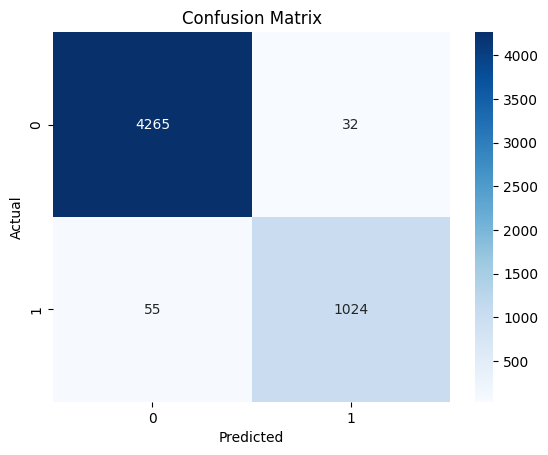

In [25]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

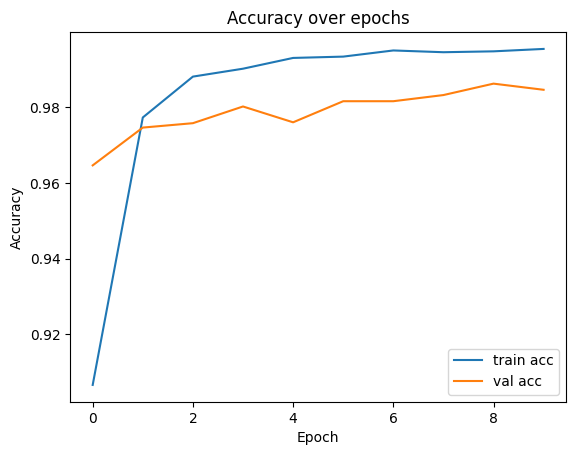

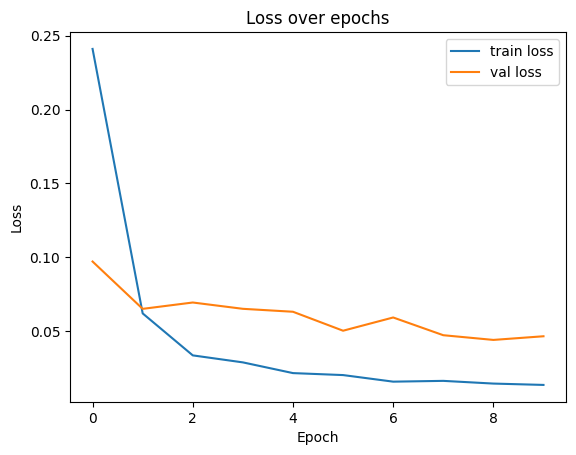

In [26]:

# Plot accuracy
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.title('Accuracy over epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot loss
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Loss over epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


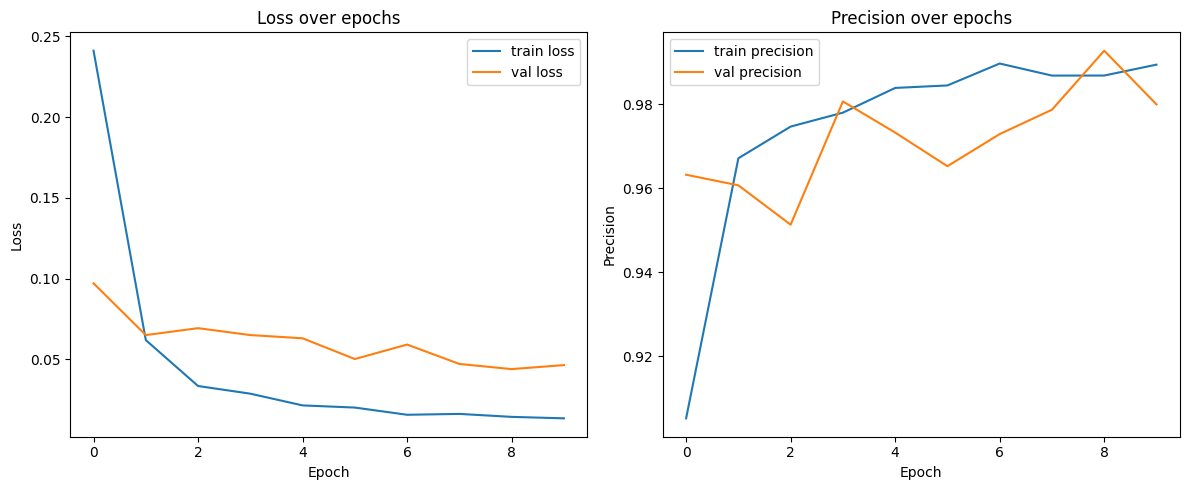

In [27]:
plt.figure(figsize=(12, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(history.history.get('loss', []), label='train loss')
plt.plot(history.history.get('val_loss', []), label='val loss')
plt.title('Loss over epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot Precision (fallback if name changes)
plt.subplot(1, 2, 2)
# Find keys containing 'precision'
precision_keys = [k for k in history.history if 'precision' in k]
train_precision_key = [k for k in precision_keys if not k.startswith('val_')][0]
val_precision_key = [k for k in precision_keys if k.startswith('val_')][0]

plt.plot(history.history[train_precision_key], label='train precision')
plt.plot(history.history[val_precision_key], label='val precision')
plt.title('Precision over epochs')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend()

plt.tight_layout()
plt.show()


In [29]:
df_future = pd.merge(df_credits, df_test3, left_on='user', right_on='user_id', how='left')

# Step 2: Add prediction-specific features
df_future['month'] = 5
df_future['year'] = 2025

# Step 3: Prepare features
df_future = pd.get_dummies(df_future, drop_first=True)
df_future = df_future.reindex(columns=X.columns, fill_value=0)

# Step 4: Scale
X_future = scaler.transform(df_future)

# Step 5: Predict
df_credits['predicted_class'] = (mlp_model.predict(X_future) > 0.5).astype(int)

# Step 6: Filter users eligible to cash out and predicted to do so
cashout_total = df_credits[
    (df_credits['credits'] >= 500) & (df_credits['predicted_class'] == 1)
]['credits'].sum()

print(f"Estimated cashout from eligible users in May 2025: {cashout_total:,.2f} CZK")

MemoryError: Unable to allocate 3.64 GiB for an array with shape (43524, 89911) and data type bool